In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import random

import torch
from datasets import ArtificialDataset
from sklearn.linear_model import LinearRegression
from cross_moment import get_beta, get_beta_sensor_fusion

import matplotlib.pyplot as plt

In [3]:
def tyc20(Z, W, D, Y):
    data_tmp = np.hstack((Z[:, None], D[:, None]))
    reg1 = LinearRegression().fit(data_tmp, W)
    W_new = reg1.predict(data_tmp)

    data_tmp = np.hstack((D[:, None], W_new[:, None]))
    reg2 = LinearRegression().fit(data_tmp, Y)
    return reg2.coef_[0]

#### Performance vs Number of samples

In [4]:
dist_name = "Exponential"
seed = 26
deg = 2
np.random.seed(seed)
torch.manual_seed(seed)
random.seed(seed)

max_samples = 50000

betas_true = np.zeros(10, dtype=float)
betas_est1 = {}
betas_est2 = {}
betas_est_sensor_fusion = {}
betas_est_tyc20 = {}
betas_est_best = {}
scale_noise = 0.1
scale_noise_Z = 0.1
scale_noise_W = 10
for i in range(10):
    alpha_d, alpha_z, beta, gamma = 0, 0, 0, 0
    while abs(alpha_d) < 0.2:
        alpha_d = -2 + 4 * np.random.rand()

    scale = 0
    while abs(scale) < 0.2:
        scale = -2 + 4 * np.random.rand()
        alpha_z = alpha_d * scale

    scale = 0
    while abs(scale) < 0.2:
        scale = -2 + 4 * np.random.rand()
        beta = alpha_d * scale

    scale = 0
    while abs(scale) < 0.5 or abs(scale) > 2:
        scale = -2 + 4 * np.random.rand()
        gamma = alpha_z * scale
        
    betas_true[i] = beta

    for n_samples in range(1000, max_samples, 2000):
        seed = np.random.randint(1000)

         # Initialize variances randomly
        rate_u, rate_d, rate_z, rate_w, rate_y = 0, 0, 0, 0, 0
        var_u, var_d, var_z, var_w, var_y = 0, 0, 0, 0, 0
        while var_u < 1:
            var_u = 10 * np.random.rand()
        var_d = scale_noise * var_u
        var_z = scale_noise_Z * var_u
        var_y = scale_noise * var_u
        var_w = scale_noise_W * var_u

        rate_u = 1./var_u
        rate_d = 1./var_d
        rate_z = 1./var_z
        rate_w = 1./var_w
        rate_y = 1./var_y
        
        dist_param = {
            "U": {"rate": rate_u},
            "D": {"rate": rate_d},
            "Z": {"rate": rate_z},
            "Y": {"rate": rate_y},
        }
        dist_conf = (dist_name, dist_param)

        # Get synthetic data
        artific_dataset = ArtificialDataset(alpha_z, alpha_d, beta, gamma, n_samples, dist_conf, seed)
        Z = artific_dataset.Z.numpy()
        D = artific_dataset.D.numpy()
        Y = artific_dataset.Y.numpy()
        eps_u = artific_dataset.eps_u.numpy()

        dist_w = torch.distributions.exponential.Exponential(rate=rate_w)
        eps_w = dist_w.sample([n_samples]).numpy()
        eps_w -= np.mean(eps_w)
        W = eps_u*alpha_z + eps_w

        # Estimate beta with Z
        beta_est1 = get_beta(Z, D, Y, deg)
        if n_samples not in betas_est1.keys():
            betas_est1[n_samples] = []
        betas_est1[n_samples].append(beta_est1)

        # Estimate beta with W
        beta_est2 = get_beta(W, D, Y, deg)
        if n_samples not in betas_est2.keys():
            betas_est2[n_samples] = []
        betas_est2[n_samples].append(beta_est2)

        # Estimate beta with cross-moments sensor fusion
        betas_sensor_fusion = get_beta_sensor_fusion(W, Z, D, Y, deg)
        if n_samples not in betas_est_sensor_fusion.keys():
            betas_est_sensor_fusion[n_samples] = []
        betas_est_sensor_fusion[n_samples].append(betas_sensor_fusion)

        # Estimate beta with tyc20 method
        if n_samples not in betas_est_tyc20.keys():
            betas_est_tyc20[n_samples] = []
        beta_est_tyc20 = tyc20(Z, W, D, Y)
        betas_est_tyc20[n_samples].append(beta_est_tyc20)

In [5]:
# Preprocess data to make a plot
x = list(range(1000, max_samples, 2000))

y_est1 = np.zeros(len(x))
yerr_est1 = np.zeros(len(x))

y_est2 = np.zeros(len(x))
yerr_est2 = np.zeros(len(x))

y_est_sensor_fusion = np.zeros(len(x))
yerr_est_sensor_fusion = np.zeros(len(x))

y_est_tyc20 = np.zeros(len(x))
yerr_est_tyc20 = np.zeros(len(x))

for i, n_samples in enumerate(range(1000, max_samples, 2000)):
    x[i] = n_samples
    
    estimates = np.abs((np.array(betas_est1[n_samples]) - betas_true) / betas_true)
    y_est1[i] = np.mean(estimates)
    yerr_est1[i] = np.std(estimates)
    
    estimates = np.abs((np.array(betas_est2[n_samples]) - betas_true) / betas_true)
    y_est2[i] = np.mean(estimates)
    yerr_est2[i] = np.std(estimates)

    estimates = np.abs((np.array(betas_est_sensor_fusion[n_samples]) - betas_true) / betas_true)
    y_est_sensor_fusion[i] = np.mean(estimates)
    yerr_est_sensor_fusion[i] = np.std(estimates)

    estimates = np.abs((np.array(betas_est_tyc20[n_samples]) - betas_true) / betas_true)
    y_est_tyc20[i] = np.mean(estimates)
    yerr_est_tyc20[i] = np.std(estimates)

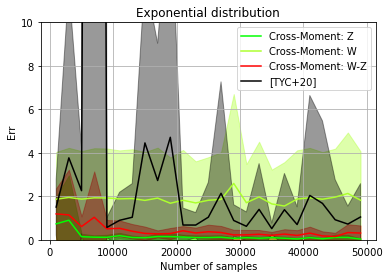

In [6]:
# Plot the results
eps=0.3
plt.title("Exponential distribution")
plt.xlabel("Number of samples")
plt.ylabel("Err")
plt.plot(x, y_est1, label="Cross-Moment: Z", color="lime")
plt.fill_between(x, y_est1 - yerr_est1, y_est1 + yerr_est1, alpha=0.6, color="lime")

plt.plot(x, y_est2, label="Cross-Moment: W", color="greenyellow")
plt.fill_between(x, y_est2 - yerr_est2, y_est2 + yerr_est2, alpha=0.4, color="greenyellow")

plt.plot(x, y_est_sensor_fusion, label="Cross-Moment: W-Z", color="red")
plt.fill_between(x, y_est_sensor_fusion - yerr_est_sensor_fusion, y_est_sensor_fusion + yerr_est_sensor_fusion, alpha=0.4, color="red")

plt.plot(x, y_est_tyc20, label="[TYC+20]", color="black")
plt.fill_between(x, y_est_tyc20 - yerr_est_tyc20, y_est_tyc20 + yerr_est_tyc20, alpha=0.4, color="black")

plt.legend(loc="upper right")
plt.grid()
plt.ylim(0, 10)
plt.savefig("./figures/comparison_tyc20.png")
plt.show()

#### Performance vs SNR rate ($W$)

In [7]:
dist_name = "Exponential"
seed = 1999
deg = 2
np.random.seed(seed)

num_points = 25
n_samples = 10000

betas_true = np.zeros(10, dtype=float)
betas_est1 = {}
betas_est2 = {}
betas_est_sensor_fusion = {}
betas_est_tyc20 = {}
betas_est_best = {}
scale_noise = 0.1
scale_noise_Z = 0.1
for i in range(10):
    alpha_d, alpha_z, beta, gamma = 0, 0, 0, 0
    while abs(alpha_d) < 0.2:
        alpha_d = -2 + 4 * np.random.rand()

    scale = 0
    while abs(scale) < 0.2:
        scale = -2 + 4 * np.random.rand()
        alpha_z = alpha_d * scale

    scale = 0
    while abs(scale) < 0.2:
        scale = -2 + 4 * np.random.rand()
        beta = alpha_d * scale

    scale = 0
    while abs(scale) < 0.5 or abs(scale) > 2:
        scale = -2 + 4 * np.random.rand()
        gamma = alpha_z * scale
        
    betas_true[i] = beta

    for scale_noise_W in np.linspace(1, 10, num=num_points):
        seed = np.random.randint(1000)

        # Initialize variances randomly
        rate_u, rate_d, rate_z, rate_w, rate_y = 0, 0, 0, 0, 0
        var_u, var_d, var_z, var_w, var_y = 0, 0, 0, 0, 0
        while var_u < 1:
            var_u = 10 * np.random.rand()
        var_d = scale_noise * var_u
        var_z = scale_noise_Z * var_u
        var_y = scale_noise * var_u
        var_w = scale_noise_W * var_u

        rate_u = 1./var_u
        rate_d = 1./var_d
        rate_z = 1./var_z
        rate_w = 1./var_w
        rate_y = 1./var_y
        
        dist_param = {
            "U": {"rate": rate_u},
            "D": {"rate": rate_d},
            "Z": {"rate": rate_z},
            "Y": {"rate": rate_y},
        }
        dist_conf = (dist_name, dist_param)

        # Get synthetic data
        artific_dataset = ArtificialDataset(alpha_z, alpha_d, beta, gamma, n_samples, dist_conf, seed)
        Z = artific_dataset.Z.numpy()
        D = artific_dataset.D.numpy()
        Y = artific_dataset.Y.numpy()
        eps_u = artific_dataset.eps_u.numpy()

        dist_w = torch.distributions.exponential.Exponential(rate=rate_w)
        eps_w = dist_w.sample([n_samples]).numpy()
        eps_w -= np.mean(eps_w)
        W = eps_u*alpha_z + eps_w

        # Estimate beta with Z
        beta_est1 = get_beta(Z, D, Y, deg)
        if scale_noise_W not in betas_est1.keys():
            betas_est1[scale_noise_W] = []
        betas_est1[scale_noise_W].append(beta_est1)

        # Estimate beta with W
        beta_est2 = get_beta(W, D, Y, deg)
        if scale_noise_W not in betas_est2.keys():
            betas_est2[scale_noise_W] = []
        betas_est2[scale_noise_W].append(beta_est2)

        # Estimate beta with cross-moments sensor fusion
        betas_sensor_fusion = get_beta_sensor_fusion(W, Z, D, Y, deg)
        if scale_noise_W not in betas_est_sensor_fusion.keys():
            betas_est_sensor_fusion[scale_noise_W] = []
        betas_est_sensor_fusion[scale_noise_W].append(betas_sensor_fusion)

        # Estimate beta with two-proxy method
        if scale_noise_W not in betas_est_tyc20.keys():
            betas_est_tyc20[scale_noise_W] = []
        beta_est_tyc20 = tyc20(Z, W, D, Y)
        betas_est_tyc20[scale_noise_W].append(beta_est_tyc20)

In [8]:
# Preprocess data to make a plot
x = list(np.linspace(1, 10, num=num_points))

y_est1 = np.zeros(len(x))
yerr_est1 = np.zeros(len(x))

y_est2 = np.zeros(len(x))
yerr_est2 = np.zeros(len(x))

y_est_sensor_fusion = np.zeros(len(x))
yerr_est_sensor_fusion = np.zeros(len(x))

y_est_tyc20 = np.zeros(len(x))
yerr_est_tyc20 = np.zeros(len(x))

for i, scale_noise_W in enumerate(np.linspace(1, 10, num=num_points)):
    x[i] = scale_noise_W
    
    estimates = np.abs((np.array(betas_est1[scale_noise_W]) - betas_true) / betas_true)
    y_est1[i] = np.mean(estimates)
    yerr_est1[i] = np.std(estimates)
    
    estimates = np.abs((np.array(betas_est2[scale_noise_W]) - betas_true) / betas_true)
    y_est2[i] = np.mean(estimates)
    yerr_est2[i] = np.std(estimates)

    estimates = np.abs((np.array(betas_est_sensor_fusion[scale_noise_W]) - betas_true) / betas_true)
    y_est_sensor_fusion[i] = np.mean(estimates)
    yerr_est_sensor_fusion[i] = np.std(estimates)

    estimates = np.abs((np.array(betas_est_tyc20[scale_noise_W]) - betas_true) / betas_true)
    y_est_tyc20[i] = np.mean(estimates)
    yerr_est_tyc20[i] = np.std(estimates)

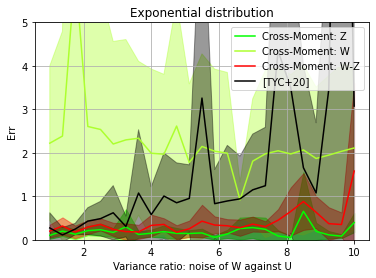

In [9]:
# Plot the results
eps=0.3
plt.title("Exponential distribution")
plt.xlabel("Variance ratio: noise of W against U")
plt.ylabel("Err")
plt.plot(x, y_est1, label="Cross-Moment: Z", color="lime")
plt.fill_between(x, y_est1 - yerr_est1, y_est1 + yerr_est1, alpha=0.6, color="lime")

plt.plot(x, y_est2, label="Cross-Moment: W", color="greenyellow")
plt.fill_between(x, y_est2 - yerr_est2, y_est2 + yerr_est2, alpha=0.4, color="greenyellow")

plt.plot(x, y_est_sensor_fusion, label="Cross-Moment: W-Z", color="red")
plt.fill_between(x, y_est_sensor_fusion - yerr_est_sensor_fusion, y_est_sensor_fusion + yerr_est_sensor_fusion, alpha=0.4, color="red")

plt.plot(x, y_est_tyc20, label="[TYC+20]", color="black")
plt.fill_between(x, y_est_tyc20 - yerr_est_tyc20, y_est_tyc20 + yerr_est_tyc20, alpha=0.4, color="black")

plt.legend(loc="upper right")
plt.grid()
plt.ylim(0, 5)
plt.savefig("./figures/comparison_tyc20_rate.png")
plt.show()